## VICTOR: Solve an ordinary differential equation (ODE) for volcano ballistic transport

Ballistic trajectories and their hazards are commonly evaluated by solving the equations for ballistic transport with drag force, which reduces the distance traveled by ballistic blocks and bombs due to the density of the atmosphere and their bomb/block shape.

This notebook gives an example of solving the ballistic transport ODE using a 4th order Runge- Kutta approximation to the ODE.


### About ballistics

Volcanic ballistic projectiles are rock fragments, either rapidly solidifying magma or pieces of conduit wall, which are transported along ballistic trajectories as a result of volcanic explosion. Volcanic ballistic projectiles are termed blocks if they are solid during their time of flight and only deform by brittle failure on impact with the ground or a structure. Volcanic bombs are also ballistic projectiles, but are sufficiently hot (hotter than the glass transition temperature of about $700^{\circ}$ C) to deform during flight and on impact.  Because volcanic ballistic projectiles can be massive, $>1000$\,kg, and have high initial velocities, 100--300 m s$^{-1}$, they can possess tremendous kinetic energy and may impart high impact force. Studies based on field observations, experiments, and theory all indicate that ballistic projectiles may have kinetic energy in excess of $10^6$ J.

The range of volcanic ballistic projectiles (horizontal distance from the vent to the impact point of the projectile) depends on the initial velocity of the projectile, the incident angle of the projectile as it leaves the vent, mass, projectile shape (as it relates to atmospheric drag), and wind velocity. Two types of volcanic ballistic projectiles are commonly identified. These are Type 1 ballistic projectiles that follow a ballistic trajectory from the vent to the impact point, and Type 2 ballistic projectiles that are carried upward to an added height by the motion of the eruption column. Type 2 ballistic projectiles might be ejected from the column at a wide range of incident angles as a result of collisions with other ballistic projectiles. The big question is: what is the potential range of ballistics (and the hazards area around the volcanic vent), given initial conditions.

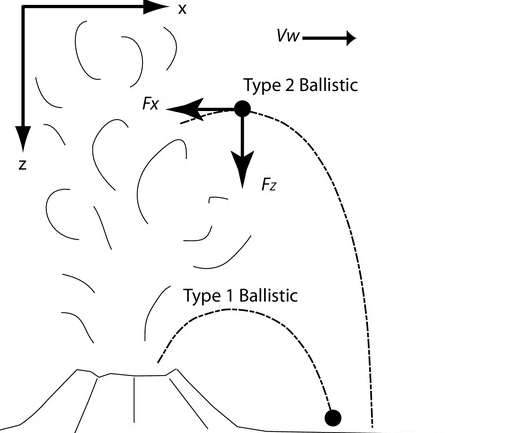

### Governing Equations

The simplest way to model ballistic transport is to use two ordinary differential equations - one for the horizontal component of velocity of the projectile, and one for the vertical component as a function of time of flight. 

$$\frac{dv_x}{dt} = -\beta v_x^2 $$
$$\frac{dv_y}{dt} = -g -\beta v_y^2 $$

$t$ is the time since the ballistic transport started, $v_x$ is the horizontal component of velocity (in the $x$ direction) and $v_y$ is the vertical component of velocity (in the $y$ direction). $g$ is gravity.

$\beta$ is the drag on the particle (try different values of $\beta$, say between 0.01 (high drag) and 0 (no drag).

Notice in the no drag case, the ODEs reduce to:

$$\frac{dv_x}{dt} = 0 $$
$$\frac{dv_y}{dt} = -g $$

which makes it easier to find an analytical solution.

### Solve with fourth order Runge-Kutta

The solution to the ODEs is obtained numerically using the fourth order Runge-Kutta numerical approximation. 

In this case, the ODEs include additional parameters (gravity and beta). These parameters must be passed through the R-K function to the functions that define the differential equations. This is done with a **kwargs statement (key word arguments). There are other ways to pass this information, but kwargs is very efficient. Notice in the code that kwargs is defined as a python dictionary.

The code consists of four parts:
1. The main part of the code, where initial conditions are specified. After initial conditions are specified, the key word dictionary is constructed. Then the R-K4 function (fourth order Runge-Kutta) is called. Note that the y component, vertical velocity component, is called first. This is because the code is run until the y coordinate value is less than zero (the projectile hits the ground at y=0), then the x-component is solved.


2. The differential equations are defined in the functions dvelx_dt and dvely_dt. Note how kwargs are passed to these function (from the main program and from R-K4), but kwargs is unpacked in the function definition, using the keywords. This makes the code more readable.


3. The R-K4 function does the fourth order Runge-Kutta approximation. Note this function builds the arrays (lists) for the total time elapsed, the velocity, and the distance travelled (by components x or y)


4. Graph the output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def RK4(f, x, y, h, total_x, **kwargs):
    #fourth order R-K solution
    # for volcanic bomb and block trajectories
    
    # f is the ODE that is solved
    # for dy/dx on left hand side of the ODE
    # h is the fixed step size (experiment to choose the right value)
    # total_x is the duration of the simulation (total length of x)
    # t (time) is passed to this function and called "x" inside the function
    # so total_x is the total flight time
    
    # **kwargs contains variables passed to the ODE function
    # besides x,y: in this case gravity and beta
    
    #initialize lists for the output
    xout=[]  # the total time elapsed
    yout = [] #the velocity in the horizontal direction v_x, or the vertical direction v_y, depending on the call
    dout = [] #the total distance traveled, in the x or y direction depending on the call
    
    # We are primarily interested in the distance travelled
    # by the projectile
    # make sure the flight path starts at 0 m
    d = 0
    
    # loop until the distance is less than zero
    # this happens for the y component when the 
    # projectile hits the ground (y=0)
    # AND
    # x is less than total_x -> this is 
    # reset after the dv/dy is calculated
    while (d >= 0 and x < total_x):
        
        # R-K solution
        k1 = f(x,y, **kwargs)
        k2 = f(x+0.5*h, y+0.5*h*k1, **kwargs)
        k3 = f(x+0.5*h, y+0.5*h*k2, **kwargs)
        k4 = f(x+h, y+h*k3, **kwargs)
        y += h/6.*(k1+2.*k2+2.*k3+k4)
        x += h
        
        # for the ballistic trajectory prob
        # y is now the distance travelled (in x or y direction depending on who is calling)
        # x is the elapsed time
        
        #calculate the distance travelled in the x or y direction
        d += y*h
        
        #build output lists
        xout.append(x) # concatenate the lists
        yout.append(y)
        dout.append(d)
    
    return xout, yout, dout



In [3]:
# ballistic equation for dvx/dt and dvy/dt
# gravity is the gravity field (9.8 m/s2)
# beta is the drag coefficient
# this could be calculated or guessed (about the same honestly!)
# t is elapsed time in flight
# v_x is horizontal component of velocity
# v_y is vertical component of velocity

def dvelx_dt(t, v_x, beta, gravity):
    return -beta*v_x**2

def dvely_dt(t, v_y, beta, gravity):
    return -gravity - beta*v_y**2

In [4]:
# main part of the code
#initial conditions
t = 0.  #at zero seconds

# about a 65 degree angle at 100 m/s
x_initial = 42.26 #m/s
y_initial = 90.63 # m/s

#set the time step. Experimentation shows this should be
# 0.001 to 0.01, or so
h = 0.01 #initial time step (s)

#set model parameters
# beta is the drag (try 0 [no drag]to 0.1 [lots of drag...its soup])
# gravity is gravity on your planet
kwargs = {"beta": .001, "gravity": 9.8}

#run time of the simulation
t_total = 10e6 #s a big number! we will stop when y distance is less than zero

# solve the ODE

# The ODEs can be solved independently for the velocity components.
#Start with "y" so we can stop when y is negative
tout, vyout, disty = RK4(dvely_dt,t, y_initial, h,t_total,**kwargs)
#returns the time, vy, and distance travelled for y component

# time = max time in y calc (when y went negative)
# pass this limit to RK4 for the vx solution
t_total = max(tout)
print ("total flight time =", t_total, "s")

#now find the vx components
tout, vxout, distx = RK4(dvelx_dt,t, x_initial, h,t_total,**kwargs)

#transform to numpy arrays if you want to
tout = np.array(tout) # np array of time (s)
dxout = np.array(distx)  # np array of x velocity (m/s)
dyout = np.array(disty)  # np array of x velocity (m/s)

total flight time = 14.969999999999725 s


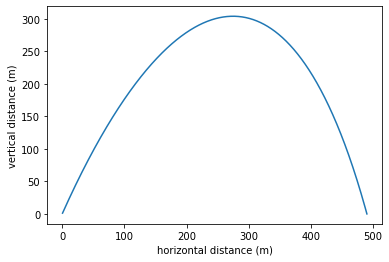

y_initial = 90.63 x_initial = 42.26 {'beta': 0.001, 'gravity': 9.8}


In [5]:
#plot the flightpath
plt.plot(dxout,dyout)
plt.xlabel("horizontal distance (m)")
plt.ylabel("vertical distance (m)")

plt.show()
print("y_initial =", y_initial, "x_initial =", x_initial, kwargs)

### More Applications

Sometimes the ODEs are writen as:

$$\frac{dv_x}{dt} = - \frac{D v_x^2}{m}$$

$$\frac{dv_y}{dt} = -g - \frac{D v_y^2}{m}$$

$$D = \frac{\rho_a A C_d}{2} $$

where $m$ is the mass of the projectile, $\rho_a$ is the density of the atmosphere, $A$ is the cross sectional area of the projectile (the area encountering the wind in profile), and $C_d$ is the drag coefficient (usually 0.5 to 1). Try implementing this version of the ODEs. Hint: add the additional terms to kwargs. Try starting with a very simple projectile geometry, like a sphere. 


Consider a start to the projectile that is not at x=0, y=0. For example, consider modeling a type2 projectile. Modify the code to accept non-zero starting position of the projectile.

How would you add wind velocity to this model?

How would you add a more realistic topography around the volcano?